In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Brownian Limit

In the Brownian limit, the ratio of the mass $m$ of the background particles to that of the selected heavy B particle $M_B$, $\lambda = \frac{m}{M_B}$, becomes small, it is then convenient to divide the particles up into two subgroups because of hte enormous difference in time scales of motion of the B and bath particles.

In the Brownian limit $\lambda = \sqrt{\frac{m}{M_B}} \rightarrow 0$, memory function for heavy particles given by delta function in time,

$$
K_v(t) = \lambda_1 \delta(t)
$$

or

$$
\tilde{K_v}(s) = \lambda_1 = \dfrac{\zeta}{M_B} = \gamma
$$

where $\gamma$ is friction coeff and $\zeta$ the friction factor $\zeta = M_B \gamma$.

## Stokes Einstein

If Stokes-Einstein holds, then friction factor $\gamma$ is

$$
\gamma = 6 \pi m_i \eta a_i
$$

$$
\gamma = \dfrac{k_B T}{m_i D_s}
$$

Now writing chosen particle's velocity $v_i$ as $V_B$ and mass as $M_B$ gives

$$
M_B \dfrac{d}{dt} V_B(t) = - \zeta V_B(t) + F_{B}^{R}(t)
$$

and

$$
\langle F_B^R(0) \rangle = 0 \\
\langle F_B^R(0) \cdot F_B^R(t) \rangle = 3 \gamma M_B k_B T \delta(t)
$$

or

$$
\langle v_i \cdot v_i \rangle = \dfrac{3k_B T}{m_i}
$$

In [2]:
Ndim = 2

N = 10000
dp = 1e-6
nu = 8.9e-4
T = 293
kB = 1.38e-23
pi = np.pi
T = 10000.0
dt = T/N

In [3]:
def get_Dtheor(T, Ndim, dp, nu):
    Dtheor = (kB*T)/(3*Ndim*pi*dp*nu)
    return Dtheor
    
Dtheor = get_Dtheor(T,Ndim,dp,nu)
print(Dtheor)

8.225985822727176e-12


In [4]:
# Variance of step size distribution
# (units of m)
var = 2*Dtheor*dt
stdev = np.sqrt(var)
print(stdev)

4.056103012184769e-06


## Verification of the Diffusion Coefficient

We are simulating random walks (integrating a single random realization of a random diffusion walk) using some parameter to control the distribution of step size. This distribution results in a diffusion coefficient.

We can verify that the diffusion coefficient we back out from the realizations of random walks matches the theoretical diffusion coefficient.

To back out the diffusion coefficient from MSD:

* Compute MSD versus lag time
* Plot MSD versus lag time
* Fit data to line - displacement vs. time
* This velocity is proportional to $v \sim \dfrac{2D}{\delta t}$

[This page](https://tinevez.github.io/msdanalyzer/tutorial/MSDTuto_brownian.html) mentions a reference for the 2D/t relation, which is also derived in the stat mech textbook mentioned in notebook 4, and is also derived (third method) in the brownian motion notes Z sent me.

In [5]:
# Single random diffusion walk

# mean 0, std dev computed above
dx = stdev*np.random.randn(N,)
dy = stdev*np.random.randn(N,)

x = np.cumsum(dx)
y = np.cumsum(dy)

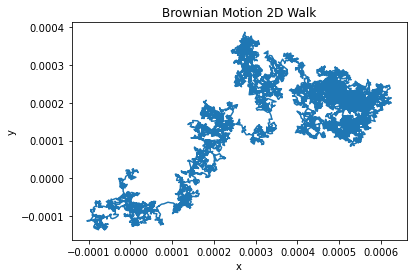

In [6]:
plt.plot(x, y, '-')
plt.xlabel('x'); plt.ylabel('y');
plt.title("Brownian Motion 2D Walk")
plt.show()

In [7]:
# Compute MSD versus lag time 
# 0 to sqrt(N) avoids bias of longer lag times
upper = int(round(np.sqrt(N)))
msd = np.zeros(upper,)
lag = np.zeros(upper,)

for i, p in enumerate(range(1,upper+1)):
    lagtime = dt*p
    delx = ( x[p:] - x[:-p] )
    dely = ( y[p:] - y[:-p] )
    msd[i] = np.mean(delx*delx + dely*dely)
    lag[i] = lagtime

In [8]:
m, b = np.polyfit(lag, msd, 1)

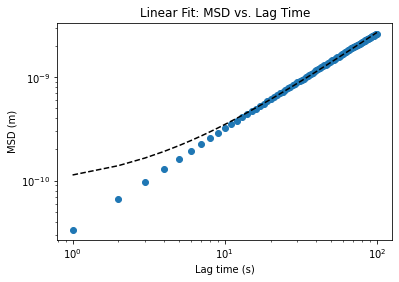

linear fit:
Slope = 2.6e-11
Intercept = 8.7e-11


In [9]:
plt.loglog(lag, msd, 'o')
plt.loglog(lag, m*lag+b, '--k')

plt.xlabel('Lag time (s)')
plt.ylabel('MSD (m)')
plt.title('Linear Fit: MSD vs. Lag Time')

plt.show()

print("linear fit:")
print("Slope = %0.2g"%(m))
print("Intercept = %0.2g"%(b))

**NOTE:** If the total time being simulated *decreases* such that timesteps are on the order of $10^{-1}$ or $10^{-2}$, the scale of the MSD becomes $10^{-14}$ and numerical error becomes significant.

In [10]:
# Slope is:
# v = dx / dt
# v = 2 D / dt
# Rearrange:
# D = v * dt / 2
v = m
Dempir = (v*dt)/2

err = (np.abs(Dtheor-Dempir)/Dtheor)*100

print("Theoretical D:\t%0.4g"%(Dtheor))
print("Empirical D:\t%0.4g"%(Dempir))
print("Percent Error:\t%0.4g"%(err))
print("\nNote: this result is from a single realization. Taking an ensemble yields a more accurate predicted D.")

Theoretical D:	8.226e-12
Empirical D:	1.305e-11
Percent Error:	58.63

Note: this result is from a single realization. Taking an ensemble yields a more accurate predicted D.


In [11]:
def msd_ensemble(T, Ndim, dp, nu, N, Nwalks):
    Dtheor = get_Dtheor(T, Ndim, dp, nu)
    
    ms    = []
    msds  = []
    msdxs = []
    msdys = []
    lags  = []
    
    for w in range(Nwalks):
    
        # Single random diffusion walk
        # mean 0, std dev computed above
        dx = stdev*np.random.randn(N,)
        dy = stdev*np.random.randn(N,)
        # accumulate
        x = np.cumsum(dx)
        y = np.cumsum(dy)

        # Compute MSD versus lag time 
        # 0 to sqrt(N) avoids bias of longer lag times
        upper = int(round(np.sqrt(N)))
        msd  = np.zeros(upper,)
        msdx = np.zeros(upper,)
        msdy = np.zeros(upper,)
        lag  = np.zeros(upper,)

        for i, p in enumerate(range(1,upper+1)):
            lagtime = dt*p
            delx = ( x[p:] - x[:-p] )
            dely = ( y[p:] - y[:-p] )
            msd[i] = np.mean((delx*delx + dely*dely)/2)
            msdx[i] = np.mean(delx*delx)
            msdy[i] = np.mean(dely*dely)
            lag[i] = lagtime

        slope, _ = np.polyfit(lag, msd, 1)
    
        ms.append( slope )
        msds.append( msd )
        msdxs.append(msdx)
        msdys.append(msdy)
        lags.append( lag )
    
    
    return (ms, msds, msdxs, msdys, lags)

In [12]:
Ndim = 2

N = 10000
dp = 1e-6
nu = 8.9e-4
T = 293
kB = 1.38e-23
pi = np.pi
T = 10000.0
dt = T/N

Nwalks = 1000

In [13]:
slopes, msds, msdxs, msdys, lags = msd_ensemble(T, Ndim, dp, nu, N, Nwalks)

In [14]:
Dempir = np.mean((np.array(slopes)*dt)/2)

err = (np.abs(Dtheor-Dempir)/Dtheor)*100

print("Theoretical D:\t%0.4g"%(Dtheor))
print("Empirical D:\t%0.4g"%(Dempir))
print("Percent Error:\t%0.4g%%"%(err))

print("\nUsing an ensemble of %d particles greatly improves accuracy of predicted D."%(N))

Theoretical D:	8.226e-12
Empirical D:	8.248e-12
Percent Error:	0.2728%

Using an ensemble of 10000 particles greatly improves accuracy of predicted D.


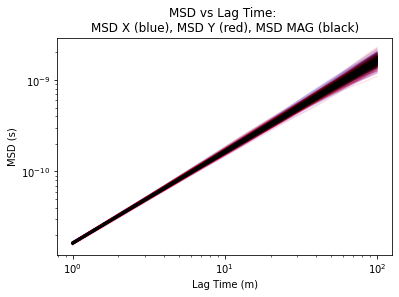

In [15]:
for i, (msd, lag) in enumerate(zip(msdxs,lags)):
    if(i>200):
        break
    plt.loglog(lag,msd,'b',alpha=0.1)

for i, (msd, lag) in enumerate(zip(msdys,lags)):
    if(i>200):
        break
    plt.loglog(lag,msd,'r',alpha=0.1)
    
for i, (msd, lag) in enumerate(zip(msds,lags)):
    if(i>200):
        break
    plt.loglog(lag,msd,'k',alpha=0.1)
    
plt.xlabel('Lag Time (m)')
plt.ylabel('MSD (s)')
plt.title('MSD vs Lag Time: \nMSD X (blue), MSD Y (red), MSD MAG (black)')
plt.show()

**NOTE:** As mentioned above, the total time being simulated needs to be large enough that the lag time is larger than $10^{-2}$. At lag times of $10^{-2}$ the MSD values are near machine truncation values, so the solution is succeptible to roundoff error.